In [1]:
#!pip install gensim
import json
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, GRU, LSTM
from tensorflow.keras import regularizers
from gensim.models import Word2Vec
import tensorflow as tf
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
def load_data(file):
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data
data2 = load_data("Processed_Laptop_Review_Train.json")

texts2 = [i['text'] for i in data2]
labels = [i['labels'] for i in data2]
words2 = [sentence.split() for sentence in texts2]

max_length = max([len(i) for i in words2])
max_length


78

In [5]:
word2vec_model = Word2Vec(words2, vector_size=100, min_count=1, epochs=10)

# Create word vectors dictionary with consistent lowercase keys
word_vectors = {}
for word in word2vec_model.wv.index_to_key:
    try:
        word_vectors[word.lower()] = word2vec_model.wv[word.lower()]
    except KeyError:
        # Handle out-of-vocabulary words
        pass

# Handle out-of-vocabulary (OOV) words in get_word_vector function
def get_word_vector(word):
    word_lower = word.lower()  # Ensure lowercase for consistency
    if word_lower in word_vectors:
        return word_vectors[word_lower]
    else:
        # Choose an appropriate strategy for OOV words:
        # - Return the zero vector (default)
        # - Use word averaging or other embedding techniques
        # - Handle OOV cases differently depending on your specific requirements
        return np.zeros(word2vec_model.vector_size)
    
word_embeddings = [[get_word_vector(word)  for word in sentence] for sentence in words2]


In [6]:
for sentence in word_embeddings:
    sentence_length = len(sentence)
    if sentence_length < 78: #max length of sentence = 70
        while len(sentence) < 78:
            sentence.append(np.zeros(100))     

# padding to convert into (9435, 78, 100)  from (9435, variable_length, 78)           
for i in range(len(word_embeddings)):
    word_embeddings[i] = np.array(word_embeddings[i])
word_embeddings = np.array(word_embeddings)
word_embeddings.shape            

(906, 78, 100)

In [9]:
flat_labels = [label for sublist in labels for label in sublist]

# Find unique labels
unique_labels = set(flat_labels)

print(unique_labels)

label2idx = {label: idx for idx, label in enumerate(unique_labels)}
labels_idx = [[label2idx[label] for label in sublist] for sublist in labels]

# One-hot encode labels
num_classes = len(unique_labels)
one_hot_labels = [to_categorical(sublist, num_classes=num_classes) for sublist in labels_idx]
print(label2idx)

{'O', 'B', 'I'}
{'O': 0, 'B': 1, 'I': 2}


In [10]:
def convert_to_list(lst):
    if isinstance(lst, np.ndarray):
        return lst.tolist()
    elif isinstance(lst, list):
        return [convert_to_list(item) for item in lst]
    else:
        return lst
one_hot_labels = convert_to_list(one_hot_labels)
# labels_idx[0]

for sentence in one_hot_labels:
    sentence_length = len(sentence)
    if sentence_length < 78: #max length of sentence = 70
        while len(sentence) < 78:
            sentence.append([1.,0.,0.])
one_hot_labels = np.array(one_hot_labels)
one_hot_labels.shape


(906, 78, 3)





5/5 [==============================] - 0s 11ms/step
Epoch 1: Training Macro-F1-score: 0.32887899034892354, Validation Macro-F1-score: 0.3288591672637529
Epoch 1: Training Accuracy: 0.9380452632904053, Validation Accuracy: 0.9735105633735657
5/5 [==============================] - 0s 13ms/step
Epoch 2: Training Macro-F1-score: 0.32887899034892354, Validation Macro-F1-score: 0.3288591672637529
Epoch 2: Training Accuracy: 0.9736263751983643, Validation Accuracy: 0.9735105633735657
5/5 [==============================] - 0s 9ms/step
Epoch 3: Training Macro-F1-score: 0.32887899034892354, Validation Macro-F1-score: 0.3288591672637529
Epoch 3: Training Accuracy: 0.9736263751983643, Validation Accuracy: 0.9735105633735657
5/5 [==============================] - 0s 17ms/step
Epoch 4: Training Macro-F1-score: 0.32887899034892354, Validation Macro-F1-score: 0.3288591672637529
Epoch 4: Training Accuracy: 0.9736263751983643, Validation Accuracy: 0.9735105633735657
5/5 [============================

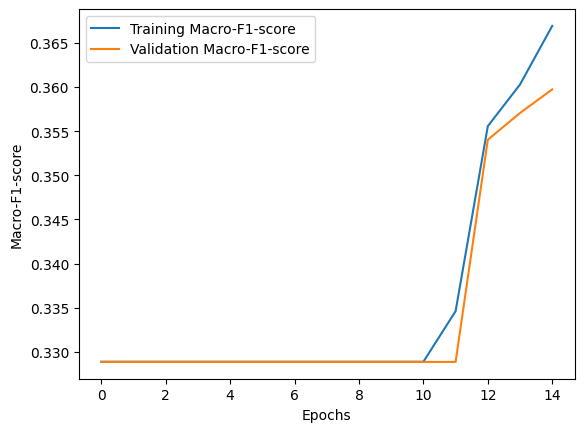

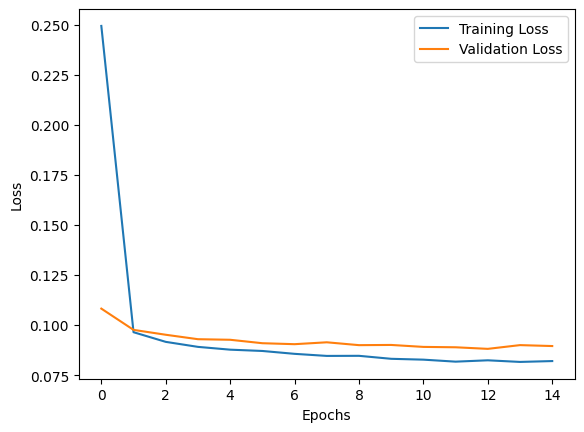

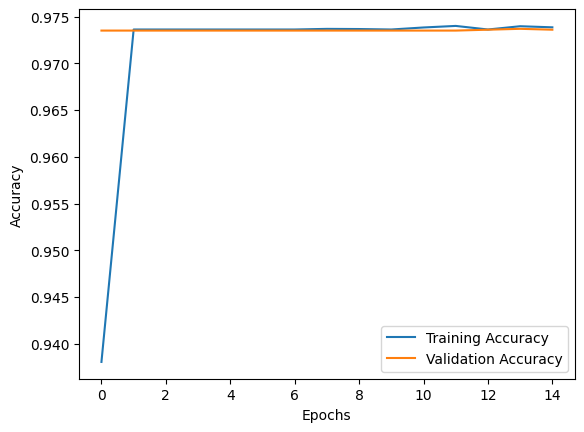

In [11]:
# 1. Prepare the data (already padded)
X_train_padded = word_embeddings  # Assuming padded word embeddings
y_train_padded = one_hot_labels     # Assuming padded labels

# Split into training and validation sets (85-15 split)
split = int(0.85 * len(X_train_padded))
X_train, X_val = X_train_padded[:split], X_train_padded[split:]
y_train, y_val = y_train_padded[:split], y_train_padded[split:]

# 2. Define the RNN model architecture
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(units=128, return_sequences=True, input_shape=(78, 100)),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the model and Initialize lists to store F1-score values
train_f1_scores = []
val_f1_scores = []
train_losses = []
val_losses = []
train_acc = []
val_acc = []

train_f1_scores_per_label = []
val_f1_scores_per_label = []

for epoch in range(15):
    # Perform one epoch of training
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=True, validation_data=(X_val, y_val))

    # Get predictions for training and validation data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Convert one-hot encoded labels back to integer labels
    y_train_true = np.argmax(y_train, axis=-1)
    y_val_true = np.argmax(y_val, axis=-1)

    # Calculate F1-score for training and validation data
    train_f1 = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average='macro')
    val_f1 = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average='macro')

    train_f1_per_label = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average=None)
    val_f1_per_label = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average=None)
    
    # Append F1-score values to lists
    train_f1_scores_per_label.append(train_f1_per_label)
    val_f1_scores_per_label.append(val_f1_per_label)
    
    # Append F1-score values to lists
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    # Append losses to lists
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    # Append accuracy to lists
    train_acc.append(history.history['accuracy'])
    val_acc.append(history.history['val_accuracy'])

    # Print F1-score and accuracy for each epoch
    print(f'Epoch {epoch + 1}: Training Macro-F1-score: {train_f1}, Validation Macro-F1-score: {val_f1}')
    print(f'Epoch {epoch + 1}: Training Accuracy: {history.history["accuracy"][-1]}, Validation Accuracy: {history.history["val_accuracy"][-1]}')

# Plot F1-score
plt.plot(train_f1_scores, label='Training Macro-F1-score')
plt.plot(val_f1_scores, label='Validation Macro-F1-score')
plt.xlabel('Epochs')
plt.ylabel('Macro-F1-score')
plt.legend()
# plt.savefig('/home/seraj/ner/task_1_best_model/final_ner_model/task_1_Fasttext_simple_RNN_f1_score.png')  # Save F1-score figure
plt.show()

# Plot Loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('/home/seraj/ner/task_1_best_model/final_ner_model/task_1_Fasttext_simple_RNN_loss.png')  # Save loss figure
plt.show()

# Plot Accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('/home/seraj/ner/task_1_best_model/final_ner_model/task_1_Fasttext_simple_RNN_accuracy.png')  # Save accuracy figure
plt.show()


In [12]:
model.save('SimpleRNN-Dataset2-Word2vec.keras')

5/5 [==============================] - 0s 15ms/step
Epoch 1: Training Macro-F1-score: 0.32887899034892354, Validation Macro-F1-score: 0.3288591672637529
Epoch 1: Training Accuracy: 0.9649683833122253, Validation Accuracy: 0.9735105633735657
5/5 [==============================] - 0s 18ms/step
Epoch 2: Training Macro-F1-score: 0.32887899034892354, Validation Macro-F1-score: 0.3288591672637529
Epoch 2: Training Accuracy: 0.9736263751983643, Validation Accuracy: 0.9735105633735657
5/5 [==============================] - 0s 19ms/step
Epoch 3: Training Macro-F1-score: 0.32887899034892354, Validation Macro-F1-score: 0.3288591672637529
Epoch 3: Training Accuracy: 0.9736263751983643, Validation Accuracy: 0.9735105633735657
5/5 [==============================] - 0s 16ms/step
Epoch 4: Training Macro-F1-score: 0.32887899034892354, Validation Macro-F1-score: 0.3288591672637529
Epoch 4: Training Accuracy: 0.9736263751983643, Validation Accuracy: 0.9735105633735657
5/5 [==============================]

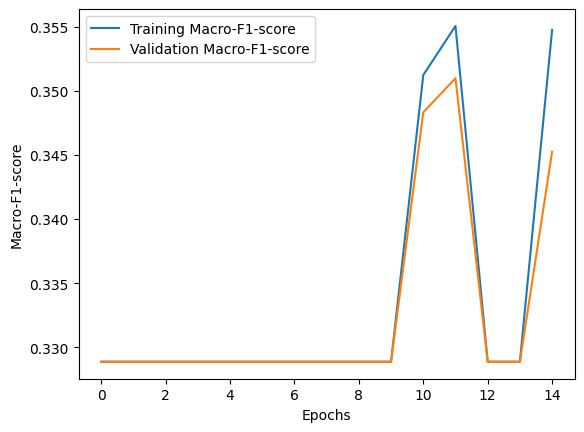

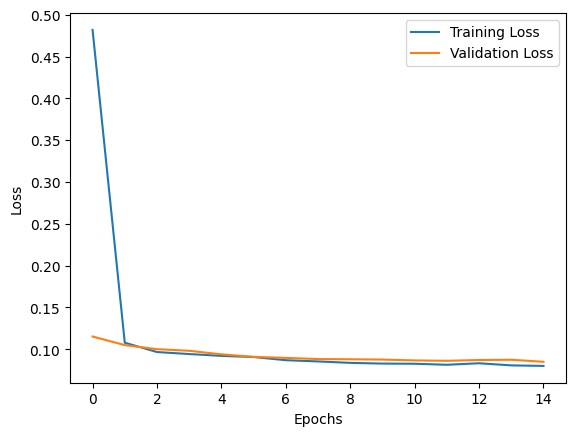

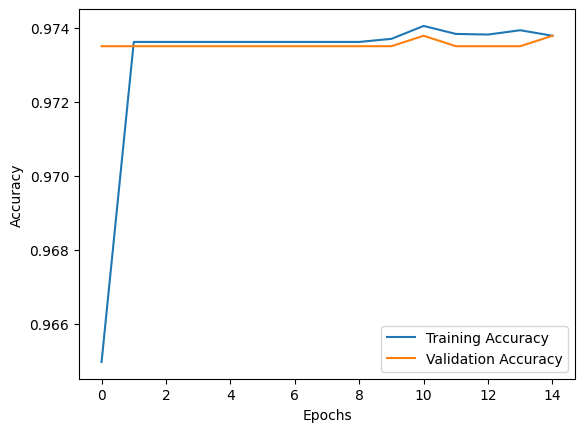

In [13]:
# 1. Prepare the data (already padded)
X_train_padded = word_embeddings  # Assuming padded word embeddings
y_train_padded = one_hot_labels     # Assuming padded labels

# Split into training and validation sets (85-15 split)
split = int(0.85 * len(X_train_padded))
X_train, X_val = X_train_padded[:split], X_train_padded[split:]
y_train, y_val = y_train_padded[:split], y_train_padded[split:]

# 2. Define the RNN model architecture
model = tf.keras.Sequential([
    tf.keras.layers.GRU(units=128, return_sequences=True, input_shape=(78, 100)),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the model and Initialize lists to store F1-score values
train_f1_scores = []
val_f1_scores = []
train_losses = []
val_losses = []
train_acc = []
val_acc = []

train_f1_scores_per_label = []
val_f1_scores_per_label = []

for epoch in range(15):
    # Perform one epoch of training
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=True, validation_data=(X_val, y_val))

    # Get predictions for training and validation data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Convert one-hot encoded labels back to integer labels
    y_train_true = np.argmax(y_train, axis=-1)
    y_val_true = np.argmax(y_val, axis=-1)

    # Calculate F1-score for training and validation data
    train_f1 = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average='macro')
    val_f1 = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average='macro')

    train_f1_per_label = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average=None)
    val_f1_per_label = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average=None)
    
    # Append F1-score values to lists
    train_f1_scores_per_label.append(train_f1_per_label)
    val_f1_scores_per_label.append(val_f1_per_label)
    
    # Append F1-score values to lists
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    # Append losses to lists
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    # Append accuracy to lists
    train_acc.append(history.history['accuracy'])
    val_acc.append(history.history['val_accuracy'])

    # Print F1-score and accuracy for each epoch
    print(f'Epoch {epoch + 1}: Training Macro-F1-score: {train_f1}, Validation Macro-F1-score: {val_f1}')
    print(f'Epoch {epoch + 1}: Training Accuracy: {history.history["accuracy"][-1]}, Validation Accuracy: {history.history["val_accuracy"][-1]}')

# Plot F1-score
plt.plot(train_f1_scores, label='Training Macro-F1-score')
plt.plot(val_f1_scores, label='Validation Macro-F1-score')
plt.xlabel('Epochs')
plt.ylabel('Macro-F1-score')
plt.legend()
# plt.savefig('/home/seraj/ner/task_1_best_model/final_ner_model/task_1_Fasttext_simple_RNN_f1_score.png')  # Save F1-score figure
plt.show()

# Plot Loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('/home/seraj/ner/task_1_best_model/final_ner_model/task_1_Fasttext_simple_RNN_loss.png')  # Save loss figure
plt.show()

# Plot Accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('/home/seraj/ner/task_1_best_model/final_ner_model/task_1_Fasttext_simple_RNN_accuracy.png')  # Save accuracy figure
plt.show()


In [14]:
model.save('GRU-Datset2-Word2vec.keras')

5/5 [==============================] - 0s 30ms/step
Epoch 1: Training Macro-F1-score: 0.32887899034892354, Validation Macro-F1-score: 0.3288591672637529
Epoch 1: Training Accuracy: 0.9522644281387329, Validation Accuracy: 0.9735105633735657
5/5 [==============================] - 0s 15ms/step
Epoch 2: Training Macro-F1-score: 0.32887899034892354, Validation Macro-F1-score: 0.3288591672637529
Epoch 2: Training Accuracy: 0.9736263751983643, Validation Accuracy: 0.9735105633735657
5/5 [==============================] - 0s 23ms/step
Epoch 3: Training Macro-F1-score: 0.32887899034892354, Validation Macro-F1-score: 0.3288591672637529
Epoch 3: Training Accuracy: 0.9736263751983643, Validation Accuracy: 0.9735105633735657
5/5 [==============================] - 0s 21ms/step
Epoch 4: Training Macro-F1-score: 0.32887899034892354, Validation Macro-F1-score: 0.3288591672637529
Epoch 4: Training Accuracy: 0.9736263751983643, Validation Accuracy: 0.9735105633735657
5/5 [==============================]

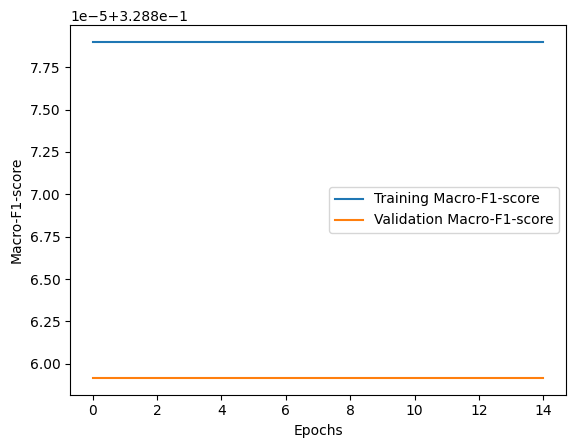

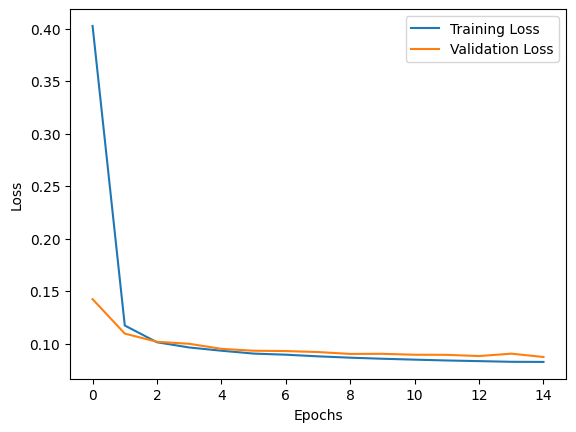

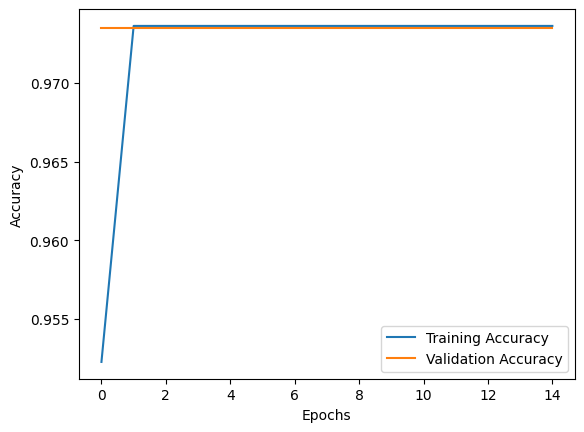

In [17]:
# 1. Prepare the data (already padded)
X_train_padded = word_embeddings  # Assuming padded word embeddings
y_train_padded = one_hot_labels     # Assuming padded labels

# Split into training and validation sets (85-15 split)
split = int(0.85 * len(X_train_padded))
X_train, X_val = X_train_padded[:split], X_train_padded[split:]
y_train, y_val = y_train_padded[:split], y_train_padded[split:]

# 2. Define the RNN model architecture
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=128, return_sequences=True, input_shape=(78, 100)),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the model and Initialize lists to store F1-score values
train_f1_scores = []
val_f1_scores = []
train_losses = []
val_losses = []
train_acc = []
val_acc = []

train_f1_scores_per_label = []
val_f1_scores_per_label = []

for epoch in range(15):
    # Perform one epoch of training
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=True, validation_data=(X_val, y_val))

    # Get predictions for training and validation data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Convert one-hot encoded labels back to integer labels
    y_train_true = np.argmax(y_train, axis=-1)
    y_val_true = np.argmax(y_val, axis=-1)

    # Calculate F1-score for training and validation data
    train_f1 = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average='macro')
    val_f1 = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average='macro')

    train_f1_per_label = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average=None)
    val_f1_per_label = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average=None)
    
    # Append F1-score values to lists
    train_f1_scores_per_label.append(train_f1_per_label)
    val_f1_scores_per_label.append(val_f1_per_label)
    
    # Append F1-score values to lists
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    # Append losses to lists
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    # Append accuracy to lists
    train_acc.append(history.history['accuracy'])
    val_acc.append(history.history['val_accuracy'])

    # Print F1-score and accuracy for each epoch
    print(f'Epoch {epoch + 1}: Training Macro-F1-score: {train_f1}, Validation Macro-F1-score: {val_f1}')
    print(f'Epoch {epoch + 1}: Training Accuracy: {history.history["accuracy"][-1]}, Validation Accuracy: {history.history["val_accuracy"][-1]}')

# Plot F1-score
plt.plot(train_f1_scores, label='Training Macro-F1-score')
plt.plot(val_f1_scores, label='Validation Macro-F1-score')
plt.xlabel('Epochs')
plt.ylabel('Macro-F1-score')
plt.legend()
# plt.savefig('/home/seraj/ner/task_1_best_model/final_ner_model/task_1_Fasttext_simple_RNN_f1_score.png')  # Save F1-score figure
plt.show()

# Plot Loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('/home/seraj/ner/task_1_best_model/final_ner_model/task_1_Fasttext_simple_RNN_loss.png')  # Save loss figure
plt.show()

# Plot Accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('/home/seraj/ner/task_1_best_model/final_ner_model/task_1_Fasttext_simple_RNN_accuracy.png')  # Save accuracy figure
plt.show()


In [16]:
model.save('LSTM-Dataset2-Word2vec.keras')

# Test data

In [ ]:
X_test_padded = word_embeddings_test
y_test_padded = one_hot_labels_test

# Evaluate the model on the test data
modelS = tf.keras.models.load_model('SimpleRNN-Dataset2-Word2vec.keras')
modelG = tf.keras.models.load_model('GRU-Dataset2-Word2vec.keras')
modelL = tf.keras.models.load_model('LSTM-Dataset2-Word2vec.keras')

from sklearn.metrics import classification_report
y_predS = modelS.predict(X_test_padded)
y_pred_classesS = np.argmax(y_predS, axis=2).flatten()
y_test_classesS = np.argmax(y_test_padded, axis=2).flatten()
target_namesS = [str(label) for label in unique_labels]
reportS = classification_report(y_test_classesS, y_pred_classesS, target_names=target_namesS)
print("SimpleRNN", reportS)

from sklearn.metrics import classification_report
y_predG = modelG.predict(X_test_padded)
y_pred_classesG = np.argmax(y_predG, axis=2).flatten()
y_test_classesG = np.argmax(y_test_padded, axis=2).flatten()
target_namesG = [str(label) for label in unique_labels]
reportG = classification_report(y_test_classesG, y_pred_classesG, target_names=target_namesG)
print("GRU", reportS)

from sklearn.metrics import classification_report
y_predL = modelL.predict(X_test_padded)
y_pred_classesL = np.argmax(y_predS, axis=2).flatten()
y_test_classesL = np.argmax(y_test_padded, axis=2).flatten()
target_namesL = [str(label) for label in unique_labels]
reportL = classification_report(y_test_classesL, y_pred_classesL, target_names=target_namesL)
print("LSTM", reportL)